In [1]:
import scanpy as sc
import torch
import lightning.pytorch as pl
from torch import nn
from torch.optim import AdamW
from self_supervision.models.lightning_modules.cellnet_autoencoder import MLPAutoEncoder
from self_supervision.estimator.cellnet import EstimatorAutoEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np
import pandas as pd

data_dir = '../../dataset/GEX_human_neocortex_filtered.h5ad'
adata = sc.read_h5ad(data_dir)
print(adata.X)
sc.pp.normalize_total(adata,target_sum=1e4)
sc.pp.log1p(adata)


# 2. 设置 checkpoint 路径
ckpt_path = "../../sc_pretrained/Pretrained Models/RandomMask.ckpt"

# 3. 模型参数
units_encoder = [512, 512, 256, 256, 64]
units_decoder = [256, 256, 512, 512]

# 初始化 EstimatorAutoEncoder 实例
estim = EstimatorAutoEncoder(data_path=None)  # 没有实际数据路径，可以设置为None

# 4. 加载预训练模型
estim.model = MLPAutoEncoder.load_from_checkpoint(
    ckpt_path,
    gene_dim=19331,  # 根据你的数据调整
    batch_size=8192,  # 根据你的需要调整
    units_encoder=units_encoder, 
    units_decoder=units_decoder,
    masking_strategy="random",  # 假设模型使用了随机掩码
    masking_rate=0.5,  # 根据需要调整
)

/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")
/home/hanchuangyi/miniconda3/envs/ssl/lib/python3.10/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 560546360 stored elements and shape (232328, 18944)>
  Coords	Values
  (0, 9055)	1.0
  (0, 484)	1.0
  (0, 8769)	1.0
  (0, 15607)	1.0
  (0, 5958)	1.0
  (0, 6754)	2.0
  (0, 10091)	4.0
  (0, 720)	1.0
  (0, 211)	2.0
  (0, 5468)	1.0
  (0, 9205)	1.0
  (0, 13556)	2.0
  (0, 550)	2.0
  (0, 5036)	1.0
  (0, 14257)	1.0
  (0, 16799)	1.0
  (0, 4038)	4.0
  (0, 4799)	1.0
  (0, 13032)	1.0
  (0, 1974)	2.0
  (0, 14845)	1.0
  (0, 17775)	3.0
  (0, 9728)	1.0
  (0, 17921)	1.0
  (0, 12549)	1.0
  :	:
  (232327, 13612)	1.0
  (232327, 4926)	1.0
  (232327, 647)	2.0
  (232327, 10195)	2.0
  (232327, 9526)	1.0
  (232327, 12032)	1.0
  (232327, 8830)	2.0
  (232327, 6370)	15.0
  (232327, 99)	3.0
  (232327, 14319)	1.0
  (232327, 14924)	1.0
  (232327, 5053)	7.0
  (232327, 9166)	4.0
  (232327, 18338)	2.0
  (232327, 10926)	1.0
  (232327, 14013)	2.0
  (232327, 2278)	1.0
  (232327, 14281)	1.0
  (232327, 11653)	1.0
  (232327, 11494)	7.0
  (232327, 13872)	1.0
  (232

In [2]:
# 添加分类层 (FC)
n_classes = len(adata.obs['cell_type'].unique())
estim.model.fc = nn.Linear(units_encoder[-1], n_classes)
n_classes

34

In [3]:
var_df = pd.read_parquet('../../sc_pretrained/var.parquet')
all_genes = var_df['feature_name'].tolist()

new_data = np.zeros((adata.X.shape[0], len(all_genes)), dtype=np.float32)

adata.var['gene_name']=adata.var.index
existing_genes = adata.var['gene_name']

In [4]:
# 将所有基因名称转换为小写
all_genes_lower = [gene.lower() for gene in all_genes]
adata_genes_lower = [gene.lower() for gene in existing_genes]

# 将两个列表转换为集合
all_genes_set = set(all_genes_lower)
adata_genes_set = set(adata_genes_lower)

# 计算交集
matching_genes = all_genes_set.intersection(adata_genes_set)
matching_count = len(matching_genes)
# 计算不匹配的基因
non_matching_genes = adata_genes_set - matching_genes
non_matching_count = len(non_matching_genes)


# 输出结果
print(f"匹配的基因数量: {matching_count}")
print(f"匹配的基因列表: {matching_genes}")
non_matching_genes

匹配的基因数量: 18944
匹配的基因列表: {'kpna5', 'asb18', 'clcn1', 'tmem100', 'crx', 'taf11l13', 'golph3', 'tgfa', 'tor2a', 'tapbp', 'parpbp', 'hipk2', 'inmt', 'spidr', 'pcdhga2', 'znf215', 'znf875', 'acvr1', 'sprr2d', 'lmf2', 'smim9', 'glis3', 'tapt1', 'fgl1', 'ct47a3', 'phka2', 'dsn1', 'thap9', 'atxn2l', 'or9i1', 'or4k14', 'gfy', 'msi1', 'pdcd5', 'ell', 'krtap4-1', 'rmdn1', 'or12d3', 'tent4a', 'wasf3', 'dydc1', 'lrrc66', 'mmp20', 'stab2', 'gigyf1', 'cdh4', 'pex5', 'emp2', 'psmc3', 'slc22a6', 'mfap3', 'chtop', 'rac3', 'arnt2', 'nudt22', 'il10', 'efcab10', 'pofut1', 'sh3rf3', 'nat10', 'cert1', 'dcaf1', 'cabp7', 'phgdh', 'yipf2', 'bicral', 'mknk2', 'c14orf28', 'thrb', 'coq6', 'zg16b', 'chrnb4', 'or4f4', 'dpagt1', 'cdk18', 'or2f2', 'fam160b1', 'bach2', 'rubcnl', 'snx20', 'opcml', 'trak2', 'tubb4a', 'prkar1b', 'usp41', 'map2', 'fancl', 'gprc6a', 'rbmx2', 'znf586', 'mmp7', 'eloa2', 'bmi1', 'ppp1r16b', 'gpr12', 'tbc1d24', 'slc29a2', 'kdm3b', 'dpf1', 'kmt5b', 'tex13a', 'cwf19l1', 'sirpb1', 'dbndd2', 'emc4'

set()

In [5]:
gene_to_index = {gene: idx for idx, gene in enumerate(all_genes_lower)}
dense_adata_X = adata.X.toarray()
for i, gene in enumerate(adata_genes_lower):
    if gene in gene_to_index:
        new_data[:, gene_to_index[gene]] = dense_adata_X[:, i]
    else:
        print(f'Gene {gene} not found in all_genes list')

In [6]:
# 使用 GPU 进行评估（如果可用）
estim.trainer = pl.Trainer(accelerator="gpu", devices=1 if torch.cuda.is_available() else None)

# 5. 数据集划分（70% 训练，15% 验证，15% 测试）
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(adata.obs['cell_type'])  # 预先编码标签


random_seed = 42

X_train_val, X_test, y_train_val, y_test = train_test_split(
    new_data, labels_encoded, test_size=0.15, random_state=random_seed)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1765, random_state=random_seed)  # 0.1765 是为了让验证集占 15%

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


In [7]:
# 将训练数据转换为张量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = torch.tensor(X_train).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_val_tensor = torch.tensor(X_val).float().to(device)
y_val_tensor = torch.tensor(y_val).long().to(device)
estim.model.to(device)

MLPAutoEncoder(
  (train_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=train_
  )
  (val_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=val_
  )
  (test_metrics): MetricCollection(
    (explained_var_uniform): ExplainedVariance()
    (explained_var_weighted): ExplainedVariance()
    (mse): MeanSquaredError(),
    prefix=test_
  )
  (encoder): MLP(
    (0): Linear(in_features=19331, out_features=512, bias=True)
    (1): SELU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): SELU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): SELU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=256, b

In [8]:
# 6. 微调模型，仅微调 encoder 的最后两层，其他层参数冻结
for param in estim.model.encoder.parameters():
    param.requires_grad = False  # 冻结所有层

# 解冻所有层
for param in list(estim.model.encoder.parameters())[-5:]:
    param.requires_grad = True

In [9]:
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, estim.model.parameters()), lr=9e-4, weight_decay=0.05)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

In [10]:
from torch.utils.data import DataLoader, TensorDataset

# 设置 batch size
batch_size = 128  # 根据实际需求调整 batch size

# 使用 TensorDataset 将训练数据和标签打包
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# 使用 DataLoader 来创建批次
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 7. 微调模型
def train_epoch(model, optimizer, loss_fn, train_loader, val_loader):
    model.train()
    total_train_loss = 0
    
    # 训练集批次训练
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 前向传播
        outputs = model.encoder(X_batch)
        logits = model.fc(outputs)
        
        # 计算损失
        loss = loss_fn(logits, y_batch)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    # 验证集
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model.encoder(X_val_batch)
            val_logits = model.fc(val_outputs)
            val_loss = loss_fn(val_logits, y_val_batch)
            total_val_loss += val_loss.item()

    # 返回平均损失
    return total_train_loss / len(train_loader), total_val_loss / len(val_loader)

In [11]:
import copy  # 用于保存模型的最佳状态

# Early Stopping 参数
patience = 20  # 如果验证损失在 10 个 epoch 中没有改善，停止训练
min_delta = 1e-4  # 最小改善幅度
patience_counter = 0
best_val_loss = float('inf')  # 初始设置为正无穷大
best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存最佳模型权重
train_losses = []
val_losses = []

# 训练 500 个 epoch
for epoch in range(500):
    train_loss, val_loss = train_epoch(estim.model, optimizer, loss_fn, train_loader, val_loader)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Validation Loss: {val_loss}')
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    # Early Stopping 检查
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss  # 更新最佳验证损失
        patience_counter = 0  # 重置 patience 计数器
        best_model_weights = copy.deepcopy(estim.model.state_dict())  # 保存当前最佳模型
        print(f"Validation loss improved to {best_val_loss}, resetting patience.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")
    
    # 如果 patience_counter 超过设置的 patience，停止训练
    if patience_counter >= patience:
        print(f"Early stopping triggered. Stopping training at epoch {epoch+1}.")
        break

# 恢复到训练中性能最好的模型权重
estim.model.load_state_dict(best_model_weights)
print("Loaded best model weights based on validation loss.")


Epoch 1, Train Loss: 0.8724337558780103, Validation Loss: 0.659405550895593
Validation loss improved to 0.659405550895593, resetting patience.


Epoch 2, Train Loss: 0.7152934424010531, Validation Loss: 0.6202595504648957
Validation loss improved to 0.6202595504648957, resetting patience.


Epoch 3, Train Loss: 0.6931855096580661, Validation Loss: 0.6133130416546986
Validation loss improved to 0.6133130416546986, resetting patience.


Epoch 4, Train Loss: 0.6813584680542244, Validation Loss: 0.5939441918235122
Validation loss improved to 0.5939441918235122, resetting patience.


Epoch 5, Train Loss: 0.672732669734092, Validation Loss: 0.5952318400253743
No improvement in validation loss. Patience counter: 1/20


Epoch 6, Train Loss: 0.6679427725043848, Validation Loss: 0.5770769536276876
Validation loss improved to 0.5770769536276876, resetting patience.


Epoch 7, Train Loss: 0.662423334963016, Validation Loss: 0.5990087145414108
No improvement in validation loss. Patience counter: 1/20


Epoch 8, Train Loss: 0.6605290553402844, Validation Loss: 0.6068166492186187
No improvement in validation loss. Patience counter: 2/20


Epoch 9, Train Loss: 0.6555392225599026, Validation Loss: 0.5808284324167412
No improvement in validation loss. Patience counter: 3/20


Epoch 10, Train Loss: 0.6525957358108554, Validation Loss: 0.5909150989501031
No improvement in validation loss. Patience counter: 4/20


Epoch 11, Train Loss: 0.6502161900843343, Validation Loss: 0.5727370785269545
Validation loss improved to 0.5727370785269545, resetting patience.


Epoch 12, Train Loss: 0.6497567733097601, Validation Loss: 0.5734170321579818
No improvement in validation loss. Patience counter: 1/20


Epoch 13, Train Loss: 0.6453898833737798, Validation Loss: 0.5713347017546713
Validation loss improved to 0.5713347017546713, resetting patience.


Epoch 14, Train Loss: 0.6430417612769489, Validation Loss: 0.5697378527113807
Validation loss improved to 0.5697378527113807, resetting patience.


Epoch 15, Train Loss: 0.6404073689042068, Validation Loss: 0.5642308045874586
Validation loss improved to 0.5642308045874586, resetting patience.


Epoch 16, Train Loss: 0.6389437261573168, Validation Loss: 0.5639417897432278
Validation loss improved to 0.5639417897432278, resetting patience.


Epoch 17, Train Loss: 0.6404576423034998, Validation Loss: 0.5656540127464267
No improvement in validation loss. Patience counter: 1/20


Epoch 18, Train Loss: 0.6384073300074631, Validation Loss: 0.5673996291972778
No improvement in validation loss. Patience counter: 2/20


Epoch 19, Train Loss: 0.6343606491899227, Validation Loss: 0.5735519669213138
No improvement in validation loss. Patience counter: 3/20


Epoch 20, Train Loss: 0.635833611411433, Validation Loss: 0.5608159199957445
Validation loss improved to 0.5608159199957445, resetting patience.


Epoch 21, Train Loss: 0.6343703717345051, Validation Loss: 0.5637644107961829
No improvement in validation loss. Patience counter: 1/20


Epoch 22, Train Loss: 0.6328286542656101, Validation Loss: 0.5583771339484623
Validation loss improved to 0.5583771339484623, resetting patience.


Epoch 23, Train Loss: 0.6332543173659795, Validation Loss: 0.5716537209875855
No improvement in validation loss. Patience counter: 1/20


Epoch 24, Train Loss: 0.6336333550260725, Validation Loss: 0.5593939576393518
No improvement in validation loss. Patience counter: 2/20


Epoch 25, Train Loss: 0.6307190100008067, Validation Loss: 0.5649569109900967
No improvement in validation loss. Patience counter: 3/20


Epoch 26, Train Loss: 0.6310830774924401, Validation Loss: 0.5631401502824092
No improvement in validation loss. Patience counter: 4/20


Epoch 27, Train Loss: 0.6314077349650775, Validation Loss: 0.5514332684841785
Validation loss improved to 0.5514332684841785, resetting patience.


Epoch 28, Train Loss: 0.6289277800793351, Validation Loss: 0.5461911662812635
Validation loss improved to 0.5461911662812635, resetting patience.


Epoch 29, Train Loss: 0.6300459097540351, Validation Loss: 0.557421604683111
No improvement in validation loss. Patience counter: 1/20


Epoch 30, Train Loss: 0.6281476842428548, Validation Loss: 0.554621180226078
No improvement in validation loss. Patience counter: 2/20


Epoch 31, Train Loss: 0.6269684921654072, Validation Loss: 0.5572516328685886
No improvement in validation loss. Patience counter: 3/20


Epoch 32, Train Loss: 0.6262590595814864, Validation Loss: 0.5514857955686339
No improvement in validation loss. Patience counter: 4/20


Epoch 33, Train Loss: 0.6262737264978332, Validation Loss: 0.551736206252933
No improvement in validation loss. Patience counter: 5/20


Epoch 34, Train Loss: 0.6264291400050291, Validation Loss: 0.5471393142864381
No improvement in validation loss. Patience counter: 6/20


Epoch 35, Train Loss: 0.6251792334881849, Validation Loss: 0.5496117837263115
No improvement in validation loss. Patience counter: 7/20


Epoch 36, Train Loss: 0.6269766986135608, Validation Loss: 0.5519990917745528
No improvement in validation loss. Patience counter: 8/20


Epoch 37, Train Loss: 0.6254670019228565, Validation Loss: 0.5490053413988469
No improvement in validation loss. Patience counter: 9/20


Epoch 38, Train Loss: 0.624914195244937, Validation Loss: 0.5485823527797238
No improvement in validation loss. Patience counter: 10/20


Epoch 39, Train Loss: 0.6244758051929279, Validation Loss: 0.5717495221358079
No improvement in validation loss. Patience counter: 11/20


Epoch 40, Train Loss: 0.6213226780752606, Validation Loss: 0.5533869885481321
No improvement in validation loss. Patience counter: 12/20


Epoch 41, Train Loss: 0.6246481776049905, Validation Loss: 0.5581299920221825
No improvement in validation loss. Patience counter: 13/20


Epoch 42, Train Loss: 0.6243650919100509, Validation Loss: 0.5536079412196582
No improvement in validation loss. Patience counter: 14/20


Epoch 43, Train Loss: 0.6220412521170969, Validation Loss: 0.5482734894796168
No improvement in validation loss. Patience counter: 15/20


Epoch 44, Train Loss: 0.6234801828532965, Validation Loss: 0.5493129528922476
No improvement in validation loss. Patience counter: 16/20


Epoch 45, Train Loss: 0.6202890597676594, Validation Loss: 0.543551586158983
Validation loss improved to 0.543551586158983, resetting patience.


Epoch 46, Train Loss: 0.621395850584884, Validation Loss: 0.5560259232809256
No improvement in validation loss. Patience counter: 1/20


Epoch 47, Train Loss: 0.6237741166404811, Validation Loss: 0.5535167660905328
No improvement in validation loss. Patience counter: 2/20


Epoch 48, Train Loss: 0.6218071134187967, Validation Loss: 0.553587732297597
No improvement in validation loss. Patience counter: 3/20


Epoch 49, Train Loss: 0.6230594177212329, Validation Loss: 0.555129009507078
No improvement in validation loss. Patience counter: 4/20


Epoch 50, Train Loss: 0.6213778963152767, Validation Loss: 0.5576711577591879
No improvement in validation loss. Patience counter: 5/20


Epoch 51, Train Loss: 0.6198873967752975, Validation Loss: 0.54169747146058
Validation loss improved to 0.54169747146058, resetting patience.


Epoch 52, Train Loss: 0.6216714451577512, Validation Loss: 0.5426615376175542
No improvement in validation loss. Patience counter: 1/20


Epoch 53, Train Loss: 0.6204076671253312, Validation Loss: 0.5728528585844425
No improvement in validation loss. Patience counter: 2/20


Epoch 54, Train Loss: 0.6216006552394594, Validation Loss: 0.5504132956812233
No improvement in validation loss. Patience counter: 3/20


Epoch 55, Train Loss: 0.6189414221268765, Validation Loss: 0.546497031773403
No improvement in validation loss. Patience counter: 4/20


Epoch 56, Train Loss: 0.6214576441176195, Validation Loss: 0.5477252423544943
No improvement in validation loss. Patience counter: 5/20


Epoch 57, Train Loss: 0.6205712215906048, Validation Loss: 0.5587944105649606
No improvement in validation loss. Patience counter: 6/20


Epoch 58, Train Loss: 0.6195245805122457, Validation Loss: 0.5562390004977201
No improvement in validation loss. Patience counter: 7/20


Epoch 59, Train Loss: 0.6200237486139233, Validation Loss: 0.5421473312945593
No improvement in validation loss. Patience counter: 8/20


Epoch 60, Train Loss: 0.6198058605756842, Validation Loss: 0.5462229358844268
No improvement in validation loss. Patience counter: 9/20


Epoch 61, Train Loss: 0.6187386281794212, Validation Loss: 0.5516855086817409
No improvement in validation loss. Patience counter: 10/20


Epoch 62, Train Loss: 0.6201891412329805, Validation Loss: 0.5617293365054078
No improvement in validation loss. Patience counter: 11/20


Epoch 63, Train Loss: 0.6198562130648541, Validation Loss: 0.5530640380286471
No improvement in validation loss. Patience counter: 12/20


Epoch 64, Train Loss: 0.6153961742702757, Validation Loss: 0.5471182122771994
No improvement in validation loss. Patience counter: 13/20


Epoch 65, Train Loss: 0.6191602308481908, Validation Loss: 0.545872702048375
No improvement in validation loss. Patience counter: 14/20


Epoch 66, Train Loss: 0.6187166983831782, Validation Loss: 0.5550602329519642
No improvement in validation loss. Patience counter: 15/20


Epoch 67, Train Loss: 0.6202903974487686, Validation Loss: 0.5492291677565801
No improvement in validation loss. Patience counter: 16/20


Epoch 68, Train Loss: 0.619087452545211, Validation Loss: 0.5496163256875761
No improvement in validation loss. Patience counter: 17/20


Epoch 69, Train Loss: 0.6196656363578784, Validation Loss: 0.5640727474794283
No improvement in validation loss. Patience counter: 18/20


Epoch 70, Train Loss: 0.6208473258042879, Validation Loss: 0.5646410642307756
No improvement in validation loss. Patience counter: 19/20


Epoch 71, Train Loss: 0.6191279269831093, Validation Loss: 0.5480980699533945
No improvement in validation loss. Patience counter: 20/20
Early stopping triggered. Stopping training at epoch 71.
Loaded best model weights based on validation loss.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


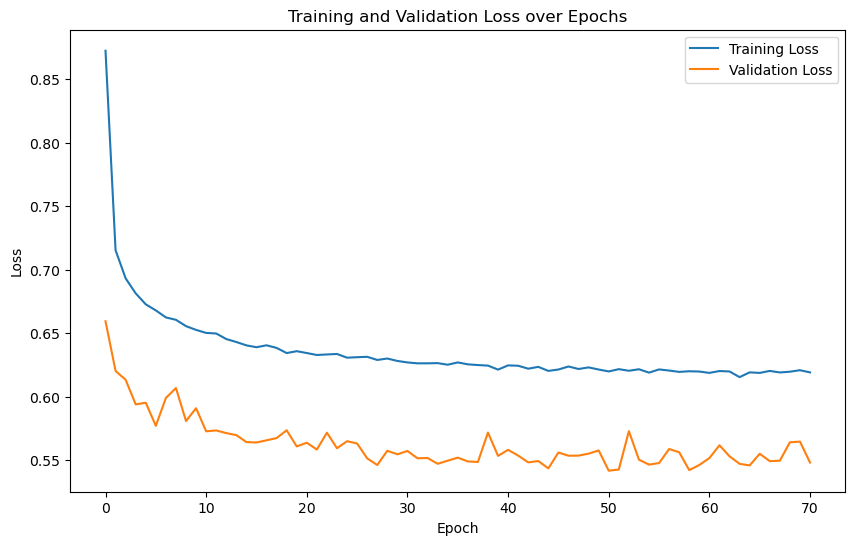

In [12]:
import matplotlib.pyplot as plt  # 导入 matplotlib.pyplot，而不是 matplotlib

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.savefig('../loss_curve_fig/merfish_human_neocortex_random_mask_finetune_full_loss_curve.png', dpi=400)  # 保存图像为png格式，400 dpi
plt.savefig('../loss_curve_fig/merfish_human_neocortex_random_mask_finetune_full_loss_curve.eps', format='eps', dpi=400)  # 保存图像为png格式，400 dpi

plt.show()


In [13]:
# 8. 使用 KNN 替代测试阶段的 FC 分类层
# 使用 encoder 提取训练集和测试集的 embedding
estim.model.eval()
with torch.no_grad():
    train_embeddings = estim.model.encoder(torch.tensor(X_train).float().to(device)).cpu().numpy()
    test_embeddings = estim.model.encoder(torch.tensor(X_test).float().to(device)).cpu().numpy()

In [14]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report

    

    # 初始化和训练KNN分类器
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(train_embeddings, y_train)
    
    # 模型预测
predictions = knn.predict(test_embeddings)

    # 计算准确率和 F1 分数
accuracy = accuracy_score(y_test, predictions)
print(f"KNN Accuracy on Test Data: {accuracy}")
f1 = f1_score(y_test, predictions, average='weighted')
print(f"Weighted F1 Score: {f1}")
    
macro_f1 = f1_score(y_test, predictions, average='macro')
print(f'Macro F1 Score: {macro_f1}')

    # 计算随机猜测的准确率
class_probabilities = np.bincount(y_test) / len(y_test)
random_accuracy = np.sum(class_probabilities ** 2)
print(f"Random Guess Accuracy: {random_accuracy}")

    # 生成分类报告
report = classification_report(y_test, predictions, target_names=label_encoder.classes_)
print(report)

KNN Accuracy on Test Data: 0.8248493543758967
Weighted F1 Score: 0.8234104166198547
Macro F1 Score: 0.7465053589078644
Random Guess Accuracy: 0.05170816843656664
                          precision    recall  f1-score   support

       Astrocyte-Fibrous       0.71      0.79      0.75       659
      Astrocyte-Immature       0.60      0.64      0.62       738
  Astrocyte-Protoplasmic       0.79      0.67      0.73       478
      Cajal-Retzius cell       0.48      0.34      0.40       123
          EN-IT-Immature       0.68      0.75      0.71      2091
              EN-L2_3-IT       0.84      0.84      0.84      1792
                EN-L4-IT       0.88      0.86      0.87      3031
                EN-L5-ET       0.66      0.50      0.57       189
                EN-L5-IT       0.89      0.87      0.88      1531
              EN-L5_6-NP       0.78      0.67      0.72       284
                EN-L6-CT       0.61      0.58      0.59       588
                EN-L6-IT       0.82      0.81

In [15]:
with torch.no_grad():
    new_data_tensor = torch.tensor(new_data).float().to(device)
    SSL_embeddings = estim.model.encoder(new_data_tensor).detach().cpu().numpy()
new_adata = sc.read_h5ad(data_dir)
new_adata.obsm[f'SSL_RM_FT_{random_seed}'] = SSL_embeddings
new_adata.uns[f'RM_FT_y_test_{random_seed}'] = y_test
new_adata.uns[f'RM_FT_predictions_{random_seed}'] = predictions
new_adata.uns[f'RM_FT_target_names_{random_seed}'] = label_encoder.classes_
new_adata.uns[f'RM_FT_train_loss_{random_seed}'] = train_losses
new_adata.uns[f'RM_FT_val_loss_{random_seed}'] = val_losses
new_adata.write_h5ad(data_dir)

In [16]:

import pandas as pd
import os
import re

# 当前 Notebook 文件名
notebook_name = "GEX_human_neocortex_random_mask_fine_tune_42.ipynb"

# 初始化需要打印的值
init_train_loss = train_losses[0] if 'train_losses' in globals() else None
init_val_loss = val_losses[0] if 'val_losses' in globals() else None
converged_epoch = len(train_losses) - patience if 'train_losses' in globals() else None
converged_val_loss = best_val_loss if 'best_val_loss' in globals() else None

# 打印所有所需的指标
print("Metrics Summary:")
if 'train_losses' in globals():
    print(f"init_train_loss\tinit_val_loss\tconverged_epoch\tconverged_val_loss\tmacro_f1\tweighted_f1\tmicro_f1")
    print(f"{init_train_loss:.3f}\t{init_val_loss:.3f}\t{converged_epoch}\t{converged_val_loss:.3f}\t{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")
else:
    print(f"macro_f1\tweighted_f1\tmicor_f1")
    print(f"{macro_f1:.3f}\t{f1:.3f}\t{accuracy:.3f}")

# 保存结果到 CSV 文件
output_data = {
    'dataset_split_random_seed': [int(random_seed)],
    'dataset': ['GEX_human_neocortex'],
    'method': [re.search(r'human_neocortex_(.*?)_\d+', notebook_name).group(1)],
    'init_train_loss': [init_train_loss if init_train_loss is not None else ''],
    'init_val_loss': [init_val_loss if init_val_loss is not None else ''],
    'converged_epoch': [converged_epoch if converged_epoch is not None else ''],
    'converged_val_loss': [converged_val_loss if converged_val_loss is not None else ''],
    'macro_f1': [macro_f1],
    'weighted_f1': [f1],
    'micro_f1': [accuracy]
}
output_df = pd.DataFrame(output_data)

# 保存到当前目录下名为 results 的文件夹中
if not os.path.exists('results'):
    os.makedirs('results')

csv_filename = f"results/{os.path.splitext(notebook_name)[0]}_results.csv"
output_df.to_csv(csv_filename, index=False)


Metrics Summary:
init_train_loss	init_val_loss	converged_epoch	converged_val_loss	macro_f1	weighted_f1	micro_f1
0.872	0.659	51	0.542	0.747	0.823	0.825
